In [1]:
import sys
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import signal
from scipy import stats
from scipy import fftpack
import itertools

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
%matplotlib notebook

#### Functions

In [5]:
def apply_notch_60Hz(data, sample_rate):
    '''
    Applies a notch filter to remove 60 Hz line noise.
    
    Inputs:
    -------
    data -- nd.array, (samples, channels)
    sample_rate -- int, Hz
    
    Outputs:
    --------
    filtered_data -- nd.array, (samples, channels)
    '''
    notch_freq = 60

    # initialize filtered signal
    filtered_data = data

    # create filter kernel using firwin
    frange = [notch_freq-0.5, notch_freq+0.5]
    order  = int(150*(sample_rate/frange[0]))
    order  = order + ~order%2

    # filter kernel
    filtkern = signal.firwin(order, frange, pass_zero=True, fs=sample_rate)

    # recursively apply to data
    filtered_data = signal.filtfilt(filtkern, 1, filtered_data, axis=0)
    
    return filtered_data

In [6]:
def lowpass_filt_design(len_signal, sample_rate, cutoff_freq=200, trans_width=0.2, order_multiple=11, plot_kern=False):
    hz = np.linspace(0, sample_rate/2, int(np.floor(len_signal/2)+1))

    ## determine order
    order = np.round(order_multiple * sample_rate / cutoff_freq) + 1
    if order%2 == 0:
        order += 1 # order must be odd for signal.firls

    shape = [1,1,0,0]
    frex = [0, cutoff_freq, cutoff_freq*(1+trans_width), sample_rate/2]

    # filter kernel
    filtkern = signal.firls(order, frex, shape, fs=sample_rate)

    if plot_kern:
        # its power spectrum
        filtkernX = np.abs(fftpack.fft(filtkern, len_signal))**2

        fig, axs = plt.subplots(1, 2)
        axs[0].plot(np.arange(-order/2, order/2)/sample_rate, filtkern, 'k')
        axs[0].set_xlabel('Time (s)')
        axs[0].set_title('Filter kernel')

        axs[1].plot(np.array(frex), shape, 'r')
        axs[1].plot(hz, filtkernX[:len(hz)], 'k')
        axs[1].set_xlim([0, cutoff_freq*(1+trans_width) + 50])
        axs[1].set_xlabel('Frequency (Hz)')
        axs[1].set_ylabel('Gain')
        axs[1].set_title('Filter kernel spectrum')
        plt.show()
    
    return filtkern

### Load data

In [7]:
dfolder = r'C:\Users\lesliec\data\eeg_pilot\mouse507190\pilot1_2020-02-28_10-33-11\recording1'
# load experiment metadata and eeg data
exp = EEGexp(dfolder, preprocess=False)
# set the sample_rate for all data analysis
sample_rate = 2500

In [8]:
eegdata, timestamps = exp.load_eegdata(frequency=sample_rate, return_type='np')
print('Recording duration: %0.1f minutes' % (np.shape(eegdata)[0]/sample_rate/60))

Recording duration: 60.2 minutes


#### Filter data (notch and lowpass)

In [9]:
filteeg = apply_notch_60Hz(eegdata, sample_rate)

# design and implement lowpass filter kernel (I have checked it with the default settings, looks good)
# filter_kernel = lowpass_filt_design(len(timestamps), sample_rate)
# filteeg = signal.filtfilt(filter_kernel, 1, filteeg, axis=0)

<IPython.core.display.Javascript object>


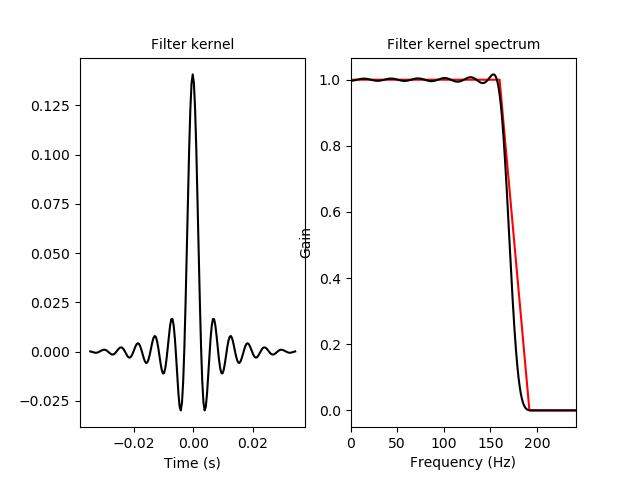

In [10]:
# design and check the lowpass filter kernel
filter_kernel = lowpass_filt_design(len(timestamps),
                                    sample_rate,
                                    cutoff_freq=160,
                                    trans_width=0.2,
                                    order_multiple=11,
                                    plot_kern=True)

In [11]:
filteeg = signal.filtfilt(filter_kernel, 1, filteeg, axis=0)

#### Load iso times

In [12]:
induction_times, anesth_times = exp.load_iso_times()
print(anesth_times)

C:\Users\lesliec\AppData\Local\Continuum\miniconda3\envs\tbd_eeg\lib\site-packages\allensdk\brain_observatory\sync_dataset.py:454: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return eval(self.dfile['analog_meta'].value)


(1194.048, 1867.552)


### Plot signal to look at bursts

<IPython.core.display.Javascript object>


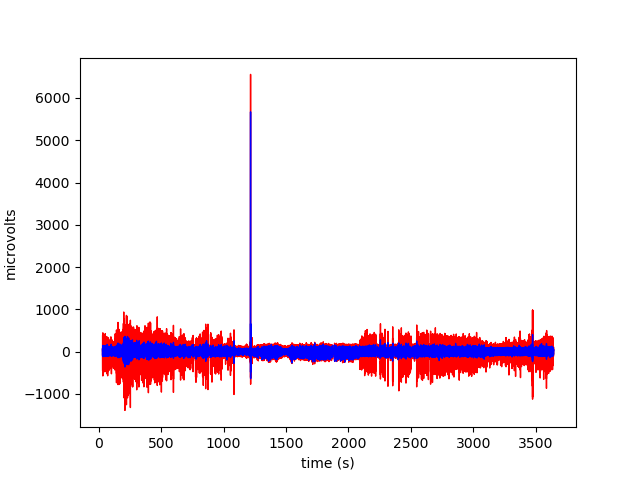

Text(0, 0.5, 'microvolts')

In [13]:
cha = 1
fig, ax = plt.subplots()

# filtered data
ax.plot(timestamps, eegdata[:,cha], 'r', linewidth=1)
ax.plot(timestamps, filteeg[:,cha], 'b', linewidth=1)

ax.set_xlabel('time (s)')
ax.set_ylabel('microvolts')

### Need a way to identify that a burst is happening.

Try calculating z-score of signal and choosing when signal crosses over a threshold.

In [14]:
# Let's select a time chunk to play with
chunkinds = np.argwhere((timestamps > 1320) & (timestamps < 1400)).flatten()
eegchunk = filteeg[chunkinds, 0:30]
print(np.shape(eegchunk))

(200003, 30)


In [15]:
zeeg = stats.zscore(eegchunk, axis=0)

<IPython.core.display.Javascript object>


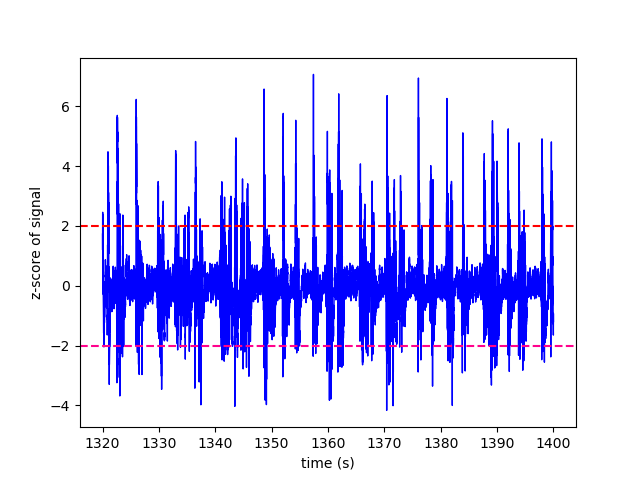

Text(0, 0.5, 'z-score of signal')

In [16]:
cha = 12
fig, ax = plt.subplots()

# zscoredata
ax.plot(timestamps[chunkinds], zeeg[:, cha], 'b', linewidth=1)
ax.axhline(y=2, color='r', linestyle='dashed')
ax.axhline(y=-2, color='#ff028d', linestyle='dashed')

ax.set_xlabel('time (s)')
ax.set_ylabel('z-score of signal')

<IPython.core.display.Javascript object>


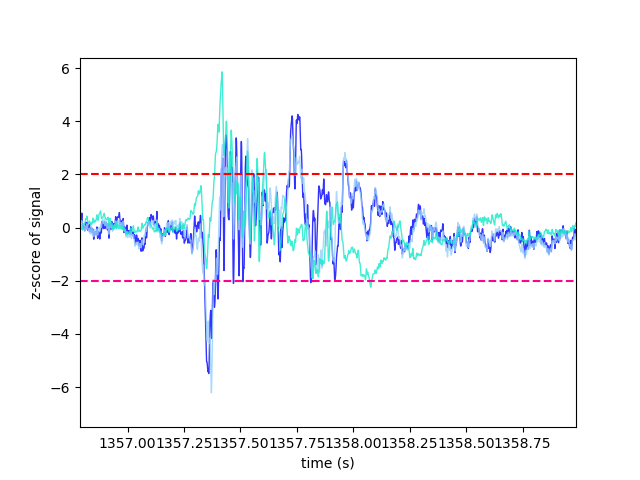

Text(0, 0.5, 'z-score of signal')

In [17]:
ch1 = 1
ch2 = 5
ch3 = 14
fig, ax = plt.subplots()

# zscoredata
ax.plot(timestamps[chunkinds], zeeg[:, ch1], 'b', linewidth=1, alpha=0.8)
ax.plot(timestamps[chunkinds], zeeg[:, ch2], '#95d0fc', linewidth=1, alpha=0.8)
ax.plot(timestamps[chunkinds], zeeg[:, ch3], '#13eac9', linewidth=1, alpha=0.8)

# view thresholds
ax.axhline(y=2, color='r', linestyle='dashed')
ax.axhline(y=-2, color='#ff028d', linestyle='dashed')

ax.set_xlabel('time (s)')
ax.set_ylabel('z-score of signal')